In [1]:
import numpy as np
import tensorflow as tf
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from pprint import pprint
from math import ceil
from time import time

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
BATCH_SIZE = 16
EPOCHS = 10
EPOCHS_BEFORE_SWA = 5
ALPHA1_LR = 0.1
ALPHA2_LR = 0.001

# Data Preparation

- load `train` and `test` subsets (CIFAR-10)
- split `train` into `train` + `valid` (80/20%, stratified split on labels)

- create data generators (with `keras.preprocessing.image.ImageDataGenerator`):
    - one ImageDataGenerator with data augmentation (horizontal flips, random translations) for train set
    - three ImageDataGenerator without data augmentation for train, valid and test subset 
        - why `train` ? : to fit Batch Norm statistics without augmentation 

In [3]:
print("... loading CIFAR10 dataset ...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

x_train, y_train = shuffle(x_train, y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=51)
# cast samples and labels
x_train = x_train.astype(np.float32) / 255.
x_val = x_val.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print("\tTRAIN - images {} | {}  - labels {} - {}".format(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype))
print("\tVAL - images {} | {}  - labels {} - {}".format(x_val.shape, x_val.dtype, y_val.shape, y_val.dtype))
print("\tTEST - images {} | {}  - labels {} - {}\n".format(x_test.shape, x_test.dtype, y_test.shape, y_test.dtype))

... loading CIFAR10 dataset ...
	TRAIN - images (40000, 32, 32, 3) | float32  - labels (40000,) - int32
	VAL - images (10000, 32, 32, 3) | float32  - labels (10000,) - int32
	TEST - images (10000, 32, 32, 3) | float32  - labels (10000,) - int32



In [4]:
generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=8, height_shift_range=8,
                                                                fill_mode='constant', cval=0.0,
                                                                horizontal_flip=True)

generator = tf.keras.preprocessing.image.ImageDataGenerator()

# python iterator object that yields augmented samples 
iterator_train_aug = generator_aug.flow(x_train, y_train, batch_size=BATCH_SIZE)

# python iterators object that yields not augmented samples 
iterator_train = generator.flow(x_train, y_train, batch_size=BATCH_SIZE)
iterator_valid = generator.flow(x_val, y_val, batch_size=BATCH_SIZE)
iterator_test = generator.flow(x_test, y_test, batch_size=BATCH_SIZE)

x : (16, 32, 32, 3) | float32
y : (16,) | int32


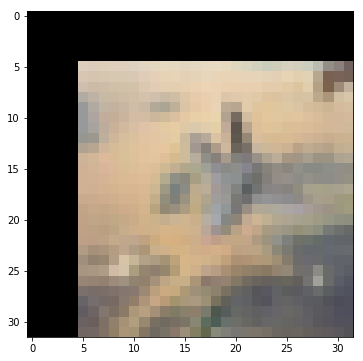

In [5]:
# test 
x, y = iterator_train_aug.next()
img = x[0]*255
print("x : {} | {}".format(x.shape, x.dtype))
print("y : {} | {}".format(y.shape, y.dtype))

plt.figure(figsize=(6,6))
plt.imshow(img.astype(np.uint8))

# Build a network with MovingFreeBatchNorm

In [6]:
from moving_free_batch_normalization import moving_free_batch_norm
from stochastic_weight_averaging import StochasticWeightAveraging

In [7]:
config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [8]:
with tf.name_scope('inputs'):
    batch_x = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32)
    batch_y = tf.placeholder(shape=[None, ], dtype=tf.int64)
    is_training_bn = tf.placeholder(shape=[], dtype=tf.bool)
    use_moving_statistics = tf.placeholder(shape=[], dtype=tf.bool)
    learning_rate = tf.placeholder(shape=[], dtype=tf.float32)

In [9]:
# network similar to a VGG11 

with tf.name_scope('network'):
    x = tf.layers.conv2d(batch_x, filters=64, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    
    x = tf.layers.conv2d(x, filters=128, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)

    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    
    
    x = tf.layers.conv2d(x, filters=256, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn, use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.conv2d(x, filters=256, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    
    
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn, use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    
    
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn, use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    
    # Global Average Pooling
    x = tf.reduce_mean(x, axis=[1, 2]) 
    logits = tf.layers.dense(x, units=10, use_bias=True)

In [10]:
model_vars = tf.trainable_variables()
pprint(model_vars)

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_1/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_1/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_2/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_2/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3,

In [11]:
# operations to update moving averages in batch norm layers
# to run before updating weights ! (with tf.control_dependencies())
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# operations to updates (mean, variance, n) in batch norm layers 
update_bn_ops = tf.get_collection('UPDATE_BN_OPS')

# operations to reset (mean, variance, n) to zero 
reset_bn_ops = tf.get_collection('RESET_BN_OPS')

pprint(update_ops)
pprint(update_bn_ops)
pprint(reset_bn_ops)

# group these operations
update_ops = tf.group(*update_ops)
update_bn_ops = tf.group(*update_bn_ops)
reset_bn_ops = tf.group(*reset_bn_ops)

[<tf.Operation 'network/moving_free_batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_1/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_2/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_2/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_3/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_3/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_4/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_4/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_5/AssignMovingAvg'

In [12]:
with tf.name_scope('loss'):
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=batch_y))
    acc_tf = tf.reduce_mean(tf.cast(tf.equal(batch_y, tf.argmax(logits, axis=1)), dtype=tf.float32))

In [13]:
with tf.name_scope('optimizer'):
    opt = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
    with tf.control_dependencies([update_ops,]):
        train_op = opt.minimize(loss_tf, var_list=model_vars)

In [14]:
with tf.name_scope('SWA'):
    swa = StochasticWeightAveraging()
    swa_op = swa.apply(var_list=model_vars)
    # Make backup variables
    with tf.variable_scope('BackupVariables'):
        backup_vars = [tf.get_variable(var.op.name, dtype=var.value().dtype, trainable=False,
                                       initializer=var.initialized_value())
                       for var in model_vars]
    # operation to assign SWA weights to model
    swa_to_weights = tf.group(*(tf.assign(var, swa.average(var).read_value()) for var in model_vars))
    # operation to store model into backup variables
    save_weight_backups = tf.group(*(tf.assign(bck, var.read_value()) for var, bck in zip(model_vars, backup_vars)))
    # operation to get back values from backup variables to model
    restore_weight_backups = tf.group(*(tf.assign(var, bck.read_value()) for var, bck in zip(model_vars, backup_vars)))

In [15]:
global_init_op = tf.global_variables_initializer()
sess.run(global_init_op)

## Set Learning rate policy 

In [16]:
def get_learning_rate(step, epoch, steps_per_epoch):
    if epoch < EPOCHS_BEFORE_SWA:
        return ALPHA1_LR

    if step > int(0.9 * EPOCHS * steps_per_epoch):
        return ALPHA2_LR

    length_slope = int(0.9 * EPOCHS * steps_per_epoch) - EPOCHS_BEFORE_SWA * steps_per_epoch
    re
    return ALPHA1_LR - ((ALPHA1_LR - ALPHA2_LR) / length_slope) * (step - EPOCHS_BEFORE_SWA * steps_per_epoch)

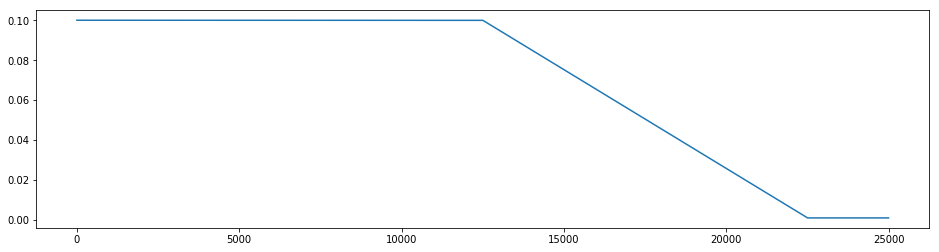

In [17]:
steps_per_epoch_train = iterator_train.n//BATCH_SIZE

all_steps = []
all_lr = []

step = 0
for epoch in range(EPOCHS):
    for _ in range(steps_per_epoch_train):
        all_steps.append(step)
        all_lr.append(get_learning_rate(step, epoch, steps_per_epoch_train))
        step += 1 

plt.figure(figsize=(16,4))
plt.plot(all_steps, all_lr)

## Launch traninig 
- create a function to fit statistics with train subset
- create a function to run inference on [train/]val/test subsets (with/without moving statistics
- create a function to run inference with SWA weights

In [18]:
steps_per_epoch_train = int(ceil(iterator_train.n/BATCH_SIZE))
steps_per_epoch_val = int(ceil(iterator_valid.n/BATCH_SIZE))
steps_per_epoch_test = int(ceil(iterator_test.n/BATCH_SIZE))

In [19]:
def fit_bn_statistics():
    sess.run(reset_bn_ops)
    
    feed_dict = {is_training_bn: True, use_moving_statistics: True}
    for _ in range(steps_per_epoch_train):
        x, y = iterator_train.next()
        feed_dict[batch_x] = x
        sess.run(update_bn_ops, feed_dict=feed_dict)

In [20]:
def inference(iterator, with_moving_statistics=True):
    feed_dict = {is_training_bn: False,
                 use_moving_statistics: with_moving_statistics}
    all_acc = []
    all_loss = []
    nb_steps = int(ceil(iterator.n/BATCH_SIZE))
    
    for _ in range(nb_steps):
        x, y = iterator.next()
        feed_dict[batch_x] = x
        feed_dict[batch_y] = y
        acc_v, loss_v = sess.run([acc_tf, loss_tf], feed_dict=feed_dict)
        all_acc.append(acc_v)
        all_loss.append(loss_v)
    
    return np.mean(all_acc), np.mean(all_loss)

In [21]:
%%time
# test your random model ? 
acc, loss = inference(iterator_valid, with_moving_statistics=True)
print("Random model : acc={:.5f}   loss={:.5f}".format(acc, loss))

Random model : acc=0.10000   loss=2.30249
CPU times: user 21.8 s, sys: 8.88 s, total: 30.7 s
Wall time: 29 s


In [22]:
%%time 
# now fit batch norm statistics and make inference again 
fit_bn_statistics()
acc, loss = inference(iterator_valid, with_moving_statistics=False)
print("Random model : acc={:.5f}   loss={:.5f}".format(acc, loss))

Random model : acc=0.09480   loss=2.53269
CPU times: user 1min 39s, sys: 38.3 s, total: 2min 18s
Wall time: 2min 14s


In [23]:
feed_dict_train = {is_training_bn: True, 
                   use_moving_statistics:True,}

In [ ]:
step = 0
start = time()

acc_train = []
loss_train = []

acc_val = []
loss_val = []

acc_val_bn = []
loss_val_bn = []

acc_val_swa = []
loss_val_swa = []

for epoch in range(EPOCHS):
    
    acc = []
    loss = []
    for _ in range(steps_per_epoch_train):
        
        feed_dict_train[learning_rate] = get_learning_rate(step, epoch, steps_per_epoch_train)
        x, y =  iterator_train_aug.next()
        feed_dict_train[batch_x] = x
        feed_dict_train[batch_y] = y
        
        acc_v, loss_v, _ = sess.run([acc_tf, loss_tf, train_op], feed_dict=feed_dict_train)
        acc.append(acc_v)
        loss.append(loss_v)
        step += 1
        
    acc = np.mean(acc)
    loss = np.mean(loss)
    acc_train.append((epoch,acc))
    loss_train.append((epoch,loss))
    print("TRAIN @ EPOCH {} : acc={:.5f}  loss={:.5f}  in {:.3f} s".format(epoch, acc, loss,
                                                                               time()-start))
    
    acc, loss = inference(iterator_valid, with_moving_statistics=True)
    acc_val.append((epoch,acc))
    loss_val.append((epoch,loss))
    print("VALID @ EPOCH {} : acc={:.5f}   loss={:.5f}  in {:.3f} s".format(epoch, acc, loss,
                                                                            time()-start))

    # now fit batch norm statistics and make inference again 
    fit_bn_statistics()
    acc, loss = inference(iterator_valid, with_moving_statistics=False)
    acc_val_bn.append((epoch,acc))
    loss_val_bn.append((epoch,loss))
    print("VALID updated bn @ EPOCH {} : acc={:.5f}   loss={:.5f}  in {:.3f} s".format(epoch, acc,
                                                                                       loss, time()-start))
    
    if epoch >= EPOCHS_BEFORE_SWA:
        sess.run(swa_op)
        
    if epoch > EPOCHS_BEFORE_SWA:
        sess.run(save_weight_backups)
        sess.run(swa_to_weights)
        
        fit_bn_statistics()
        acc, loss = inference(iterator_valid, with_moving_statistics=False)
        acc_val_swa.append((epoch,acc))
        loss_val_swa.append((epoch,loss))
        print("VALID with SWA @ EPOCH {} : acc={:.5f}   loss={:.5f}  in {:.3f} s".format(epoch, acc,
                                                                                         loss, time()-start))
        
        sess.run(restore_weight_backups)

TRAIN @ EPOCH 0 : acc=0.33632  loss=1.80784  in 555.822 s
VALID @ EPOCH 0 : acc=0.32030   loss=2.26033  in 585.007 s
VALID updated bn @ EPOCH 0 : acc=0.43340   loss=1.51867  in 734.108 s
TRAIN @ EPOCH 1 : acc=0.49085  loss=1.41674  in 1245.526 s
VALID @ EPOCH 1 : acc=0.52660   loss=1.38642  in 1274.491 s
VALID updated bn @ EPOCH 1 : acc=0.55820   loss=1.22307  in 1426.498 s
TRAIN @ EPOCH 2 : acc=0.57248  loss=1.20919  in 1924.985 s
VALID @ EPOCH 2 : acc=0.42920   loss=1.87827  in 1950.423 s
VALID updated bn @ EPOCH 2 : acc=0.62640   loss=1.07354  in 2082.893 s
TRAIN @ EPOCH 3 : acc=0.62680  loss=1.07984  in 2599.358 s
VALID @ EPOCH 3 : acc=0.56520   loss=1.39566  in 2627.226 s
VALID updated bn @ EPOCH 3 : acc=0.65010   loss=1.01985  in 2783.791 s
TRAIN @ EPOCH 4 : acc=0.66347  loss=0.97796  in 3320.516 s
VALID @ EPOCH 4 : acc=0.64350   loss=1.03858  in 3349.541 s
VALID updated bn @ EPOCH 4 : acc=0.68600   loss=0.90761  in 3498.834 s
TRAIN @ EPOCH 5 : acc=0.70213  loss=0.87313  in 4008.